# Metrics

In this notebook are the metrics used to compare the different embeddings.

## M1 Downstram Classification

This metric can be found in the additional notebook "LSTM" as it turned out to be a micro capstone-project in itself :-)

## M2 Clustering by Subsystem

This metric I have not found in the literature. The basic idea is clustering / classification in the embedding vector space. As the 

To implement, I used sklearn k-NN classification, which can be configured to use cosine distance as the distance measure. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html



An alternative not followed up here would be using a silheutte score for given clusters of words:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html


## M3 Word Analogy

In this "metric", I will try to use the well documented vector-addition properties of word embeddings in the form of 

a:b::c:d


e.g. 


King:Man::Queen:Woman

or in vector addition:

King-Man+Woman=Queen 


## M4 Word Similarity List
This is a well-known intrinsic measure for word embeddings. I adapt it here to the domain specific realm of automotive engineering. For this purpose I compile a list of wordpairs like the well known "wordsim353" and ask colleagues to provide a similarity measure between 0 and 10. This human similarity score is then (Pearson-) correlated to the cosine-similarity of the embeddings.


## M5 Visualizations

Visualizations are not a quantitative metric, however they provide (with limitations) qualitative insights about the properties of edmbeddings. Here I the one of the most commomly used algorithms: t-SNE.

In [ ]:
import pickle
import keras
import pandas as pd
import pickle
import gensim
import fasttext
from gensim.models import FastText, Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from scipy.stats import pearsonr


import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

%matplotlib inline

In [7]:
# Load Word Vectors

#Load pretrained FastText
model_ft =  KeyedVectors.load_word2vec_format('../WordEmbeddings/FastText/cc.de.300.vec') 

#Load domain specific FastText
model_ds_ft = FastText.load("../WordEmbeddings/ft_ds.model")

#Load domain specific word2vec
model_ds_w2v = Word2Vec.load("../WordEmbeddings/w2v_ds.model")


In [49]:
print(len(model_ds_w2v.wv.vocab))
print(len(model_ds_ft.wv.vocab))
print(len(model_ft.wv.vocab))

91716
91716
2000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#model_ft['Getriebe']
model_ft.get_vector('Zylinder')

array([ 0.0302, -0.0021,  0.0121, -0.0206, -0.0801, -0.0096,  0.0264,
       -0.0125, -0.0196,  0.0497,  0.0041, -0.0541,  0.0067,  0.0442,
        0.0008, -0.0069,  0.0596,  0.017 ,  0.0262, -0.0511, -0.0142,
        0.0484,  0.0196, -0.0175,  0.0066,  0.0532, -0.0125, -0.0182,
        0.0032, -0.0496, -0.0075,  0.0318, -0.0316,  0.0004, -0.0266,
        0.0096,  0.0427, -0.0186,  0.029 , -0.013 ,  0.0304, -0.0372,
       -0.0102,  0.0125,  0.0337,  0.0347,  0.0449, -0.0143, -0.0444,
       -0.0149, -0.0488,  0.0004, -0.0041,  0.0387, -0.0062, -0.0812,
       -0.013 , -0.0464,  0.0023, -0.0503, -0.024 ,  0.0208,  0.0545,
        0.0016,  0.0231,  0.0503,  0.0433, -0.0195, -0.0071, -0.0187,
        0.0035, -0.0352, -0.0085, -0.0411,  0.0492,  0.0076,  0.0315,
       -0.015 , -0.0301,  0.0106, -0.075 ,  0.0019, -0.0759,  0.019 ,
        0.006 ,  0.022 , -0.0294, -0.023 ,  0.0019, -0.0538,  0.0117,
        0.03  ,  0.0147,  0.0253, -0.0059, -0.0207,  0.0409,  0.0044,
       -0.004 ,  0.0

In [34]:
import gensim
from gensim.models import word2vec
word2vec_CRs = gensim.models.Word2Vec.load("../RelatedWork/w2v_CRs")

In [42]:
ft_matrix = word2vec_CRs.wv.get_keras_embedding(train_embeddings=False)


In [44]:
from gensim.test.utils import datapath
model = gensim.models.Word2Vec.load("../RelatedWork/w2v_CRs")
similarities = model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))
print(similarities)

((0.5336101992975493, 0.46638980070245073), SpearmanrResult(correlation=0.39999999999999997, pvalue=0.6), 98.86685552407933)


# M1: Downstram Classification

In [ ]:
# M1 LSTM
# Hier einfach die Pipeline übernehmen und die verschiedenen embeddings einsetzen. 
# Dazu brauche ich dann word vector und token liste... 

# M2: Subsystem Classification in Vector Space

Clustering oder Klassifikation. Mal schauen...

+ Suche je 10 Worte aus 3 Gruppen aus (später vielleicht 30 Worte aus 5 Gruppen...)
+ Schreibe die Worte in ein Array
+ Mache Lookup des Word Vectors für diese Worte mit der jeweiligen Repräsentation und speichere in einem Matrix


In [73]:
# Fingerübungen zu KNN Clustering und KNN Classification

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# just using the cosine distance function
x=[[1,2,3]]
y=[[4,5,6]]
print(cosine_distances(x,y))


#KNN Clustering w/ cosine distance
samples = [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
knn = NearestNeighbors(metric='cosine')
knn.fit(samples)


# KNN Classification
X_train =[[1], [2], [3], [4],[5]]
y_train = [0,0,1,1,1]
knnc=KNeighborsClassifier(metric='cosine', n_neighbors=3)
knnc.fit(X_train, y_train)
y_pred=knnc.predict(X_train) 
print(y_pred)
print(accuracy_score(y_train, y_pred, normalize=True, sample_weight=None))                            
print(knnc.predict([[1.4]]))
print(knnc.predict_proba([[0.9]])) 

[[0.02536815]]
[0 0 0 0 0]
0.4
[0]
[[0.66666667 0.33333333]]


0.7045454545454546
[[9 0 0 0 0]
 [4 5 0 0 0]
 [0 0 5 2 1]
 [1 3 0 6 0]
 [2 0 0 0 6]]


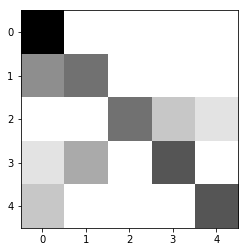

In [104]:
# M2 Clustering by subsystem

classes = [engine, transmission, control_unit, vehicle, exhaust]
models = [model_ds_ft, model_ds_w2v, model_ft]

engine = ['motor', 'einspritzung', 'zündung', "zündkerze", "wasserpumpe", "nockenwelle", "kurbelwelle", "starter", "generator"]
transmission = ['getriebe', "gang", "schlupf", "kupplung", "einlegen", "zahnrad", "gang", "automatik", "schaltgetriebe"]
control_unit = ["steuergerät", "funktion", "applikation", "regler", "tsk", "architektur", "variable", "parameter"]
vehicle = ["can", "kombiinstrument", "gaspedal", "fahrwerk", "chassis", "pedal", "mil", "esp", "abs", "lenkrad"]
exhaust = ["lambdasonde", "dpf", "opf", "katalysator", "abgas", "emission", "nox", "co2"]

data = engine+transmission+control_unit+vehicle+exhaust

X_train = [model_ft[word] for word in data]
y_train = [1]*len(engine)+[2]*len(transmission)+[3]*len(control_unit)+[4]*len(vehicle)+[5]*len(exhaust)

knnc=KNeighborsClassifier(metric='cosine', n_neighbors=3)
knnc.fit(X_train, y_train)
y_pred=knnc.predict(X_train) 

print(accuracy_score(y_train, y_pred, normalize=True, sample_weight=None))

def check_existence(list, model):
    flag = True
    for word in list:
        if word not in model.wv.vocab:
            print("{} in Class {} not found in Embedding {}".format(word, c, model))
            flag = False
    return flag

for model in models:
    for c in classes:
        #print(check_existence(c, model))
        pass

cm = confusion_matrix(y_train, y_pred, labels=None, sample_weight=None)
    
print(cm)
plt.imshow(cm, cmap='binary')

# M3: Word Analogy

In [114]:
# M3 Word Analogy

#Word Analogies:
#(positive=['woman', 'king'], negative=['man'])

a1 = ["diesel", "dieselmotor", "benzin", "ottomotor",]
a2 = ["motor", "motorsteuergerät", "getriebe", "getriebesteuergerät"]
a3 = ["benzin","fremdzündung","diesel","selbstzündung"]
a4 = ["can","botschaft","flexray","pdu"]
a5 = ["wasser", "wasserpumpe", "benzin", "benzinpumpe"]
a6 = ["benzin", "tank", "strom", "batterie"]

analogies = [a1,a2,a3,a5,a6]

def analogy(quartet):
    #result_ft = model_ft.most_similar(positive=[quartet[0], quartet[1]], negative=[quartet[2]])
    result_ds_ft = model_ds_ft.most_similar(positive=[quartet[0], quartet[1]], negative=[quartet[2]])
    result_ds_w2v = model_ds_w2v.most_similar(positive=[quartet[0], quartet[1]], negative=[quartet[2]])

    return result_ds_ft[:5], result_ds_w2v[:5]

for a in analogies:
    print(analogy(a))

([('turbodieselmotor', 0.8738648295402527), ('dieselmotore', 0.8524552583694458), ('dieselmotors', 0.8507183194160461), ('dieselmoto', 0.8442535400390625), ('ottomotor', 0.837376594543457)], [('otto', 0.8808187246322632), ('ottomotor', 0.8782336115837097), ('dieselmotoren', 0.8254048824310303), ('nkw', 0.8103951811790466), ('ottomotoren', 0.8034964799880981)])
([('motorsteue', 0.8250179290771484), ('motorsteu', 0.8179201483726501), ('motormanage', 0.7947388887405396), ('motorsteuerger−t', 0.7931571006774902), ('motorsteuerge', 0.790145754814148)], [('motorsteuerung', 0.7153784036636353), ('empfangszeit', 0.6869455575942993), ('abfühleinrichtungen', 0.6833028197288513), ('steuermodul', 0.6775274872779846), ('überwachen', 0.6653618812561035)])
([('nebenzündung', 0.86788010597229), ('zündung', 0.8610290288925171), ('entzündung', 0.8535094857215881), ('frühzündung', 0.8506962060928345), ('„zündung', 0.8475021123886108)], [('zünden', 0.9065707325935364), ('ladungsschichtung', 0.892493426799

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


# M4 Word Similarity

In [27]:
DATA_SOURCE = "list"

#Loading data from disk
if DATA_SOURCE == "disk":
    data = pd.read_csv('../Data/sim_list_N_o.tsv', delimiter ='\t',header = None)
    df_human_score = pd.read_csv('../Data/human_score.tsv', header = None) 
    e1 = [e.lower() for e in data[0]]
    e2 = [e.lower() for e in data[1]]
    words = [(e1,e2) for (e1,e2) in zip(e1,e2)]
    human_score = [s for s in df_human_score[0]]
    
    
#Loading data from list
if DATA_SOURCE == "list":
    words_original=[("riemenstartergenerator","rsg"),("motorsteuergerät","msg"),("haltemanagementsystem","hms"),
       ("batterymanagementsystem","bms"),("stateofcharge","soc"),("konzernschaltprogramm","ksp"),
        ("hochvoltkoordinator","hvk"),("geschwindigkeitsregelanlage","gra"),("triebstrangkoordinator","tsk"),
        ("functionondemand","fod"),("automatictransmissionfluid","atf"),("on boarddiagnose","obd"),("dieselpartikelfilter","dpf"),
        ("ottopartikelfilter","opf"),("electronicstabilitycontrol","esc"),("antriebssteuergeraet","asg"),("vorderachse","va"),
        ("intelligenterparkassistent","ipa"),("praediktivereffizienzassistent","pea"),("intelligentspeedassistent","isa"),
        ("Motor","Zylinder"),("tsk","laengsbeschleunigungsregler"),("Drehzahl","Schub"),("Hybrid","phev"),("Brennstoffzelle","Anode"),
        ("Brennstoffzelle","Kathode"),("kraftstoff","diesel"),("getriebe","k0"),("Display","Anzeige"),("Monitoring","Überwachung"),
        ("Wasserstoff","H2"),("motor","vkm"),("EMaschine","Strom"),("Bremspedal","Kriechen"),("Emissionen","nox"),("Druckventil","entllueftung"),
       ("fahrpedal","moment"),("wählhebel","einlegen"),("kupplung","getriebe"),("dl382","schaltung"),("phev","cbev"),("pumpe","öl"),
        ("wärme","heizen"),("saugrohrdruck","drosseln"),("drehzahl","anzeige"),("drehzahl","antrieb"),("leerlauf","schaltung"),
    ("mqb","golf"),("meb","bev"),("entprellung","signal"),("brennstoffzelle","purgeventil"),("adpcus","signal"),
    ("startstopp","leerlauf"),("drehmoment","achsfunktionalität"),("rampe","momentengradient"),("rekuperation","potential"),
    ("asg","msg"),("antrieb","leistung"),("sekundaerachse","ankoppeln"),("waehlhebel","kupplung")]

    words=[("motorsteuergerät","msg"),
       ("motor","zylinder"),
       ("drehzahl","schub"),
       ("brennstoffzelle","anode"),
       ("kraftstoff","diesel"),
       ("display","anzeige"),
       ("monitoring","überwachung"),
       ("emissionen","nox"),
       ("kupplung","getriebe"),
       ("pumpe","oel"),
       ("wärme","heizen"),
       ("drehzahl","anzeige"),
       ("drehzahl","antrieb"),
       ("leerlauf","schaltung"),
       ("asg","msg"),
       ("antrieb","leistung")]
    human_score = (9, 6, 3, 6, 7, 8, 8, 7, 6, 5, 7, 4, 5, 1, 5, 6)

In [29]:
similarity_ds_ft = [model_ds_ft.wv.similarity(e1, e2) for (e1, e2) in words]
similarity_ds_w2v = [model_ds_w2v.wv.similarity(e1, e2) for (e1, e2) in words]
similarity_ft = [model_ft.wv.similarity(e1, e2) for (e1, e2) in words]

score_ds_ft = pearsonr(similarity_ds_ft, human_score)
score_ds_w2v = pearsonr(similarity_ds_w2v, human_score)
score_ft = pearsonr(similarity_ft, human_score)

print("Score with domain specific FastText: {}".format(score_ds_ft[0]))
print("Score with domain specific word2vec: {}".format(score_ds_w2v[0]))
print("Score with general FastText: {}".format(score_ft[0]))

Score with domain specific FastText: 0.4055059106623955
Score with domain specific word2vec: 0.41986010811768953
Score with general FastText: -0.2801245403099004


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#This plots a t_SNE of the complete embedding. Might give an impression of the quality of learned embeddings? 


from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels




def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label some random data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


x_vals, y_vals, labels = reduce_dimensions(model_ds_ft)
plot_with_matplotlib(x_vals, y_vals, labels)     

# M5: Visualizations

In [51]:
model=model_ds_ft

keys = ['benzin', 'diesel']
keys2 =['motor','getriebe']
keys3 =['','']
embedding_clusters = []
word_clusters = []
for word in keys2:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [52]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=12, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

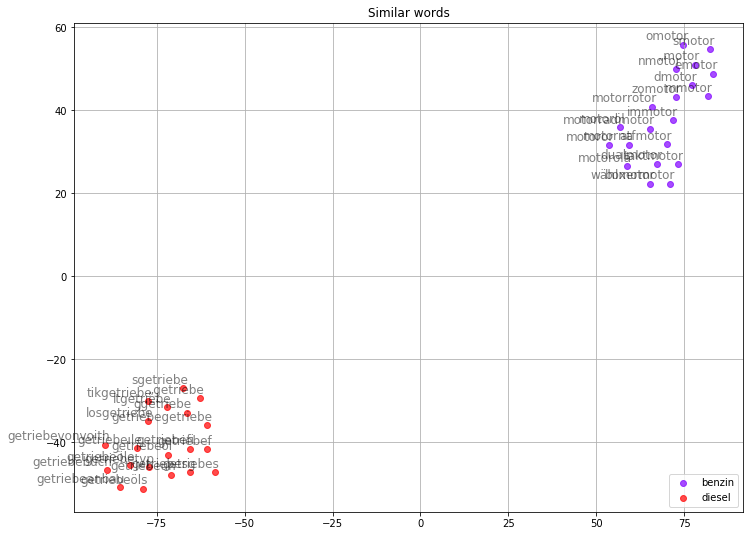

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(12, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')